# KNN regression - Cross Validation

<a target="_blank" href="https://colab.research.google.com/github/concordia-grad-computing-seminars/data-engineering/blob/main/ML/knn/knn_reg-cross_validation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Libraries

In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
%matplotlib inline

## Data

To illustrate how to perform cross validation on a KNN regressor in [`scikit-learn`](https://scikit-learn.org/stable/) we will generate a synthetic data set.

The the data are generated based on the equation $y = w_o + w_1 x + \epsilon$, where $\epsilon$ is some random noise we add. 

We start be defining the values of $w_o$ and $w_1$.

In [2]:
wo = -1.0
w1 = +2.0

### Generate a data set

We generate a data set of $m$ points by adding Gaussian noise $\epsilon \sim N(0,\sigma)$ to the ideal model.<br>
Note: to simplify later the plotting of the trained model, we sort the random X values (try to run the same notebook without this sorting to understand why)

In [3]:
sigma = 0.5
m = 25

X = np.sort(np.random.rand(m))
y = wo + w1*X + np.random.normal(0, sigma, m)

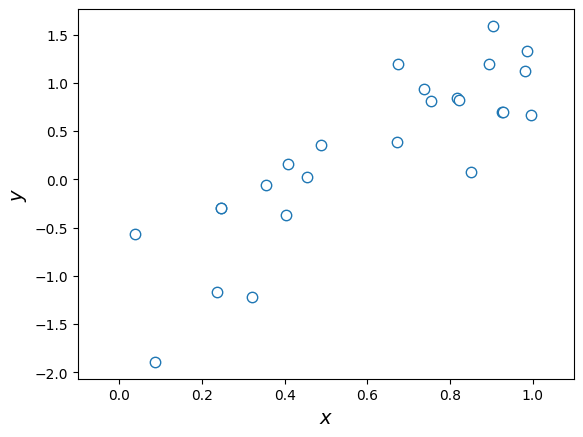

In [4]:
plt.plot(X, y, ".", markersize=15, markerfacecolor='white')
plt.xlim([-0.1, 1.1])
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show()

## Train KNN regressors with Scikit-Learn

We aim to train a k-nearest neighbor regressor. Before being able to train a KNN regressor, we need to reshape our `X` values.

In [5]:
# Reshape X into an array as required by sciKit-learn (column vector with the features)
X_b = X.reshape((-1, 1))

KNN regression can be achieved with a [`KNeighborsRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) object:

In [6]:
reg = KNeighborsRegressor(n_neighbors=5)

The question is: how do we choose the hyper-parameter `n_neighbors` (number of nearest neighbors) ?

As show the figures below, training KKN models results in very different outputs depending on the choice of the hyper-parameter `n_neighbors`.

*Question:* Can you explain the case for `n_neighbors=1` ? Why the model fits exactly all points in the data set?

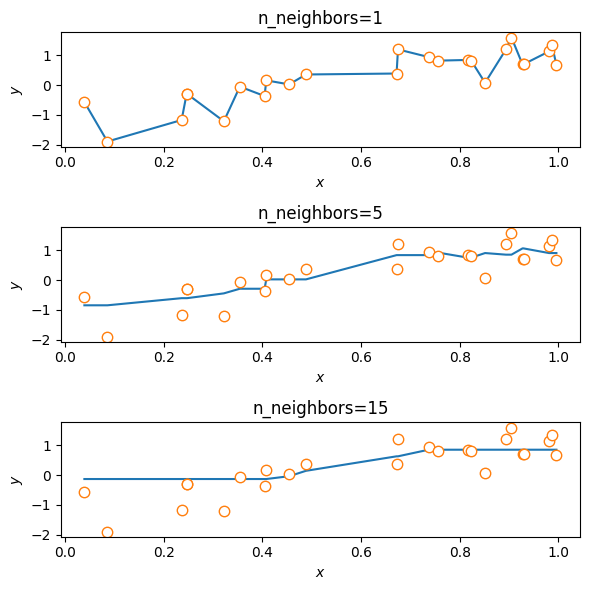

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6))
i = 0
for n in [1, 5, 15]:
    reg = KNeighborsRegressor(n_neighbors=n)
    reg.fit(X_b, y)
    y_fit = reg.predict(X_b)
    ax[i].plot(X, y_fit, "-")
    ax[i].plot(X, y, ".", markersize=15, markerfacecolor='white')
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_title('n_neighbors=' + str(n))
    i = i + 1
plt.tight_layout()
plt.show()

Which trained model is the best?<br>
* The first case seems to reproduce exactly the data set. But will it generalize well?
* The second case (`n_neighbors=5`) seems a good fit of the overall trend and will probably generalize well.
* The last case (`n_neighbors=15`) doesn't look right. And it is unlikely to generalize well.

How can we decide which is best? We explain here the usage of cross validation to address this question.

## Cross validation

### Principle

The idea of cross validation is to train a model on two distinct sets: a training set and a validation set.<br>
One then evaluates the error on the validation set and the error on the training set.<br>
Good practice is to repeat this procedure on several constructed sets (for example 5 as in the figure below) and then takes the average values.

![5-Fold cross validation](img/CrossValidation.png)

Each couple of training/validation set is referred to as a "fold". Various approaches exist to build a fold. A simple one (as on the figure) consists in splitting the full data set one has into K (in the figure K=5) splits. In each folds on chooses one of the splits as the validation sets and keeps all others as training set.

Alternative ways consist in choosing randomly points from the data set to create a training and a validation set.

In Scikit-Learn several of these techniques are implemented and documented [here](https://scikit-learn.org/stable/modules/cross_validation.html).

### Model selection with cross validation

Cross validation is a useful tool to help tuning hyper-parameters of a model. This is called *model selection*.

The principle is simple: on evaluates, using cross validation, the error on a training and validation set in function of the hyper-parameter one aims to tune. Plotting these errors in function of the hyper-parameter results in the so-called *learning curve*. Analyzing the shapes of the learning curves allows to select the value for the hyper-parameter which has the best chance to result in a model which generalize well.

Scikit Learn has, among others, the function [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) to perform cross validation. It requires essentially the following parameters (more are available for fine tuning):
* an `estimator`: any Scikit object having a `fit` method (such as `KNeighborsRegressor` for example)
* a data set: given as a features matrix (as for the `fit` method) and a array of target values
* `cv`: the number of folds (5 in the example of the figure above)
* a `scoring` measure: must be a loss function (i.e. the smaller its value, the better). Examples can be found in the official [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).

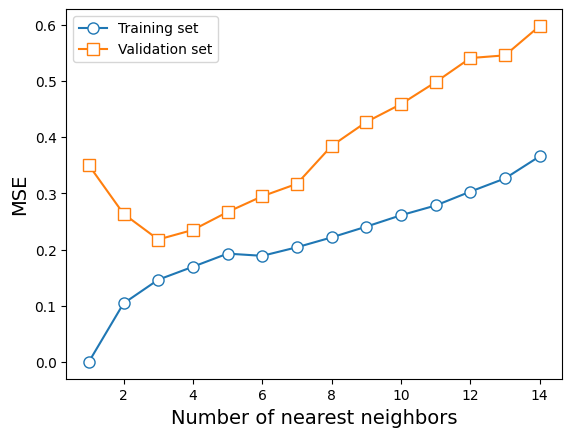

In [8]:
reg = KNeighborsRegressor()
MSE_train = []
MSE_valid = []

n_max = 15
n_range = range(1, n_max)
for n in n_range:
    reg = KNeighborsRegressor(n_neighbors=n)
    reg.fit(X_b, y)
    scores = cross_validate(reg, X_b, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    MSE_train = np.append(MSE_train, -scores['train_score'].mean())
    MSE_valid = np.append(MSE_valid, -scores['test_score'].mean())

plt.plot(range(1, n_max), MSE_train, "o-", markersize=8, markerfacecolor='white', label='Training set')
plt.plot(range(1, n_max), MSE_valid, "s-", markersize=8, markerfacecolor='white', label='Validation set')
plt.xlabel('Number of nearest neighbors', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend(loc='best')
plt.show()

Inspecting the learning curves allows to draw the following conclusions:
* For low values of `n_neighbors`, the test set as very low error, whereas the validation set as high error. The model will not generalize well. On says: the model is over-fitted
* For high values of `n_neighbors`, both: training and validation sets have large error: the mode will not generalize well neither. On says: the model is under-fitted
* For intermediate values of `n_neighbors`, the validation set has the lowest error. It is likely to generalize best.

The value of the hyper paramter `n_neighbors` which is giving the model that is likely to generalize the best way, is the one giving the lowest error on the valdiation set:

In [9]:
n_opt = n_range[np.argmin(MSE_valid)]
n_opt

3

## Making predictions

Let us now have a closer look to the model fitted with the optimal value of `n_neighbors`

In [10]:
reg = KNeighborsRegressor(n_neighbors=n_opt)
reg.fit(X_b, y)

KNeighborsRegressor(n_neighbors=3)

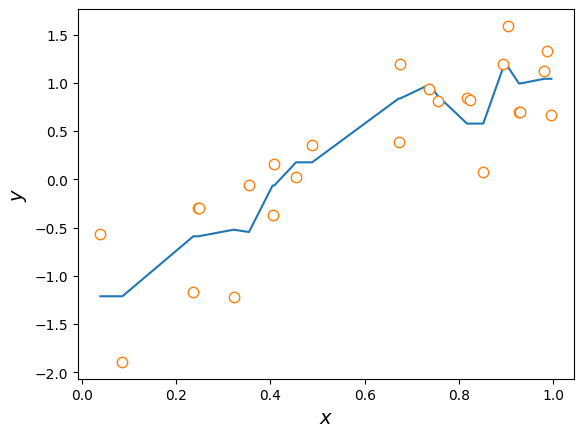

In [11]:
y_fit = reg.predict(X_b)

# Plotting data set and the fitted model
plt.plot(X, y_fit, "-")
plt.plot(X, y, ".", markersize=15, markerfacecolor='white')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show()

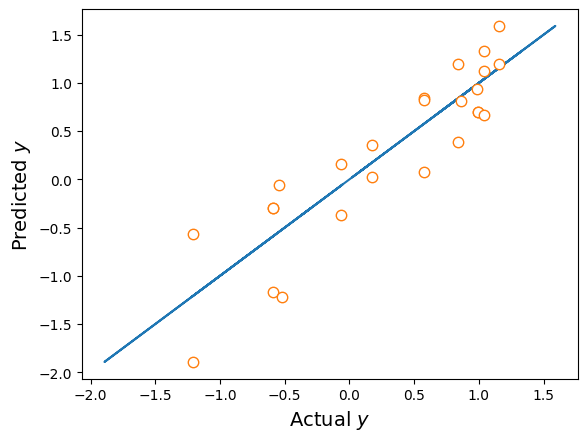

In [12]:
y_pred = reg.predict(X_b)

plt.plot(y, y, "-")
plt.plot(y_pred, y, ".", markersize=15, markerfacecolor='white')
plt.xlabel('Actual $y$', fontsize=14)
plt.ylabel('Predicted $y$', fontsize=14)
plt.show()